In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd, numpy as np, re, time
import itertools
import seaborn as sns
sns.set(style = "whitegrid", color_codes = True,font_scale = 1.5)
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [260]:
df = pd.read_csv("train-balanced-sarcasm.csv")

# EDA

In [261]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [262]:
print("Number of Comments:", len(df))

Number of Comments 1010826


In [263]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [264]:
print("Number of Sarcastic Comments", len(df.loc[df['label'] == 1]))
print("Number of Non-Sarcastic Comments", len(df.loc[df['label'] == 0]))

Number of Sarcastic Comments 505413
Number of Non-Sarcastic Comments 505413


Authors who commented the most?


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

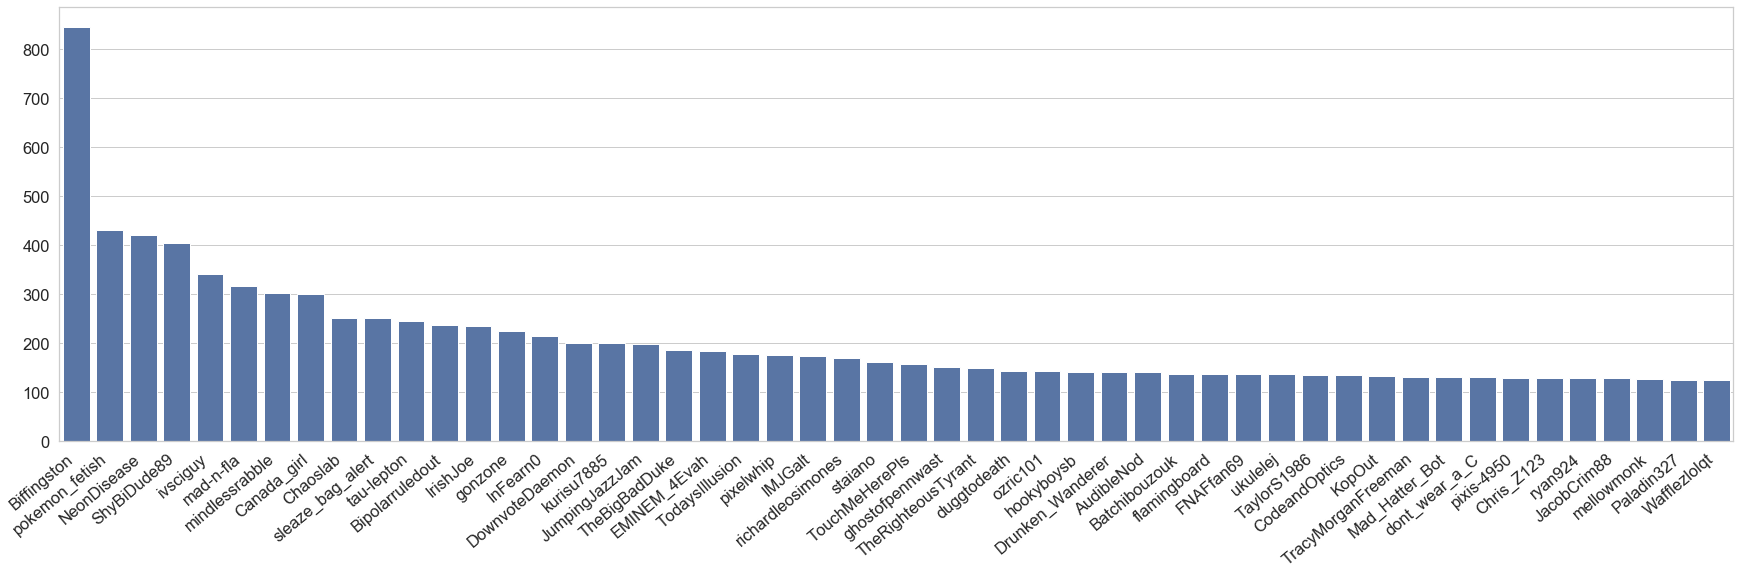

In [265]:
print("Authors who commented the most?")
plt.figure(figsize = (30,8))
star_count = df['author'].value_counts().sort_values(ascending=False)
sns.barplot(star_count.index[:50],star_count.values[:50],color='b')
plt.xticks(rotation=40,horizontalalignment='right')

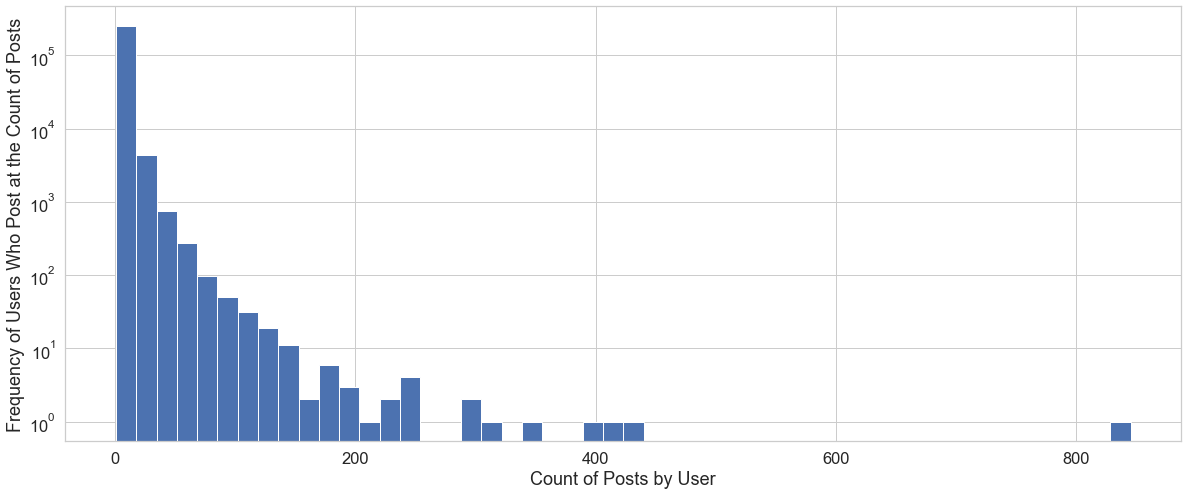

In [266]:
plt.figure(figsize = (20,8))
sns.distplot(star_count.values,kde=False,color='b', hist_kws=dict(alpha=1))
plt.yscale('log', nonposy='clip')
plt.xlabel("Count of Posts by User")
plt.ylabel("Frequency of Users Who Post at the Count of Posts")
plt.show()

**As we can see here, there is an outliar amongst the authors of the reddit posts. One redditor in particular (username "Biffingston") posts a disproportionate amount compared the others. However, since the number of comments is exponential in comparison to the rest of the users, it shouldn't have too much of an effect.**

# Subsetting the Data

In [267]:
df = pd.read_csv("train-balanced-sarcasm.csv")

In [268]:
sample_size = input()

50000


In [269]:
df = df.sample(int(sample_size))
df.reset_index(drop=True,inplace=True)

# Data Cleaning

In [270]:
df.dropna(axis = 0,how='any')

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Seeing the ad for this movie got me so excited,czervick212,batman,1,1,0,2016-03,2016-03-25 12:15:29,All the suits in the Lego Batman Movie trailer
1,0,He's just doing the Kansas City Shuffle.,DeLuca2400,AskReddit,2,2,0,2015-08,2015-08-21 18:23:47,Josh Harnett.
2,1,But how will I be constantly up to date on eve...,Kick_Kass,baseball,3,3,0,2013-12,2013-12-14 16:58:02,One can only hope.
3,0,10/10 Would watch again.,Cipher70,Showerthoughts,1,1,0,2016-02,2016-02-15 16:24:11,Deadpool should have leaked a fake version of ...
4,1,Was never wrong,natlouwet,AskReddit,0,0,0,2015-07,2015-07-24 01:37:18,What does the opposite sex do you wish your ge...
5,0,I think we found one of the only people thinki...,Sterling__Archer_,news,-4,-4,0,2015-08,2015-08-06 02:53:10,Guys I found the cop in this thread
6,1,He's got a much more lethal tool - the bible.,SnackieOnasis416,toronto,1,1,0,2016-09,2016-09-30 07:59:17,This man speaks the truth. Can we please give ...
7,0,TIL the President doesn't cast his vote in D.C.,Shell-of-Light,hillaryclinton,10,-1,-1,2016-10,2016-10-08 02:05:53,Obama casts early ballot for Clinton in Chicago
8,1,"Too late, you already triggered me.",DankrudeSandstorm,TumblrInAction,37,37,0,2015-07,2015-07-06 16:04:27,"Eat, purge, repeat.* *But don't, Bulimia is ba..."
9,0,Quitting is often not an option: people have t...,daimoneu,Anarchism,4,4,0,2012-07,2012-07-31 15:57:05,"Safe word for wage labor is, ""I quit!"""


In [271]:
print(len(df))

50000


In [272]:
print(df.isnull().any(axis = 0))

label             False
comment            True
author            False
subreddit         False
score             False
ups               False
downs             False
date              False
created_utc       False
parent_comment    False
dtype: bool


**The data above indicates that there are some null values amongst the comments. This would interfere with the analysis of the comments.**

## Figuring out the NaN float values which are causing issues

In [273]:
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

50000
50000


In [274]:
start = time.time()

counter = 0
i_count = 0
bad_indices = []

for i,string in enumerate(features):
    try:
        if isinstance(string, float):
            counter += 1
            bad_indices.append(i_count)
    except:
        pass
    i_count += 1

print(counter)
print("i_count:", i_count)
print("bad_indices:", bad_indices)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

2
i_count: 50000
bad_indices: [16181, 22922]
0.03961801528930664 seconds


In [275]:
print(len(df))

50000


In [276]:
# Drop the rows that contain unusable values (float values in this case) 
for b in bad_indices:
    df = df.drop([b])
print(len(df))

49998


In [277]:
# df now has the dropped rows!
print(len(df))

49998


In [278]:
# New features!
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

49998
49998


In [279]:
start = time.time()

counter = 0
i_count = 0
for i in df.itertuples():
    if not i[2]:
        counter += 1
        print(counter)
    i_count += 1

print(counter)
print("i_count", i_count)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

0
i_count 49998
0.12064409255981445 seconds


# Modeling

In [280]:
start = time.time()

In [281]:
# Stemming data: reducing a word to its word stem
ps = PorterStemmer()

features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [282]:
end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

10.958477020263672 seconds


In [283]:
#TF-IDF: Transoform text to meaningful numerical representation
tv = TfidfVectorizer(max_features = 5000)
# features = list(features)
features = tv.fit_transform(features).toarray()

In [284]:
# Training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [285]:
# Using linear support vector classifier
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))

0.7292938650048423
0.672


In [286]:
# Using Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))

0.6738599519979789
0.6212


In [287]:
# Using Logistic Regression
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7191039622720957
0.6792


In [288]:
# Using Random Forest Classification
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test)) 

0.9666301739020591
0.6472


# New Dataset: "News Headlines"

In [9]:
# SOURCE: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection
# NOTES - Dataset is much cleaner, less spelling errors, higher modeling scores overall
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)

In [10]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [11]:
print("Number of Headlines:", len(df))

Number of Headlines: 28619


In [12]:
print(df.isnull().any(axis = 0))

article_link    False
headline        False
is_sarcastic    False
dtype: bool


In [15]:
features = df['headline']
labels = df['is_sarcastic']
print(len(features))
print(len(labels))

28619
28619


## Modeling with Machine Learning Algorithms

In [16]:
# Stemming data: reducing a word to its word stem
ps = PorterStemmer()

features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [17]:
#TF-IDF: Transoform text to meaningful numerical representation
tv = TfidfVectorizer(max_features = 5000)
# features = list(features)
features = tv.fit_transform(features).toarray()

In [18]:
# Training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [19]:
# Using linear support vector classifier
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))

0.9050684125349419
0.8218029350104822


In [20]:
# Using Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))

0.8031852287774018
0.7169811320754716


In [21]:
# Using Logistic Regression
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8796527879947036
0.8301886792452831


In [22]:
# Using Random Forest Classification
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test)) 

0.9900691481535971
0.777078965758211
